For this project, I've worked to understand the results of an A/B test run by an e-commerce website. My goal was to show my work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [2]:
# Read data
df = pd.read_csv('https://raw.githubusercontent.com/ozlerhakan/ab-test/master/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape

(294478, 5)

In [4]:
# How long did the test run for?
df['timestamp'] = pd.to_datetime(df.timestamp)
print('total run time: ', df.timestamp.max()-df.timestamp.min())

total run time:  21 days 23:59:49.081927


In [5]:
# Computing unique number of id's usinf nunique function
df.user_id.nunique()

290584

In [6]:
converted = round(float(df.converted.mean()),4)
converted

0.1197

In [7]:
# Conditional statement to count number of rows where treatment group does not correspond with new landing page
df[((df['group'] == 'treatment') != (df['landing_page'] == 'new_page')) == True].shape[0]

3893

In [8]:
df.isnull().sum() # No null values in any column


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [9]:
# Import into df2 only rows which specify above conditions
df2 = df[((df.group == 'treatment') == (df.landing_page == 'new_page')) &
         ((df.group == 'control') == (df.landing_page == 'old_page'))]

In [10]:

# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
# How many unique **user_id**s are in **df2**?
df2.user_id.nunique()

290584

In [12]:
# There is one **user_id** repeated in **df2**.  What is it?
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

In [13]:
# What is the row information for the repeat **user_id**? 
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:

# Drop the raw with an index 2893 and update the original data frame
df2 = df2.drop(df.index[2893]);

In [15]:
converted_prob = round(float(df2.converted.mean()),4)
converted_prob

0.1196

In [16]:
control_prob = round(float((df2.query('group == "control"')['converted'] == 1).mean()),4)
control_prob

0.1204

In [17]:

treatment_prob = round(float((df2.query('group == "treatment"')['converted'] == 1).mean()),4)
treatment_prob

0.1188

In [18]:
new_page_prob = round(float((df2.query('landing_page == "new_page"')['user_id'].nunique())/(df2.shape[0])),4)
new_page_prob

0.5001

brief recap - 

There is a little difference between conversion probabilities, which can serve as statistical evidence that a new landing page leads to more conversions. The probablity of users converting in both control and treatment groups is also quite similar to the probability of users converting regardless of the page they received.

Overal probability of an individual converting, regardelss of landing page type, is 11.96%
Control group has a conversion probability of 12.04%
Treatment groupgroup has a conversion probability of 11.88%
The probability of user receiving new landing page is 50.01%

In [19]:
# What are the P_old and P_new values
# Assuming P_new and P_old are equal, they will have exactly the same formulas and values
p_new = df2.query('converted == 1')['user_id'].nunique()/df2.shape[0]
p_new

0.11959708724499628

In [20]:
p_old = df2.query('converted == 1')['user_id'].nunique()/df2.shape[0]
p_old # The answer will be identical to p_new

0.11959708724499628

In [21]:
# n_new
# Number of unique users who received new landing page
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
n_new 

145310

In [22]:
# n_old
# Number of unique users who received old landing page
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_old

145274

In [23]:
# Randomly alocate 0s and 1s with probability p_new under the null, in an array of a size n_new.
new_page_converted = np.random.binomial(1, p_new, n_new) # REVIEW
new_page_converted

array([0, 0, 1, ..., 0, 0, 0])

In [24]:
# As above the same is performed for old landing page
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
# Find difference, p_{new} - p_{old}, for simulated values from part (e) and (f).# 
diff = sum(new_page_converted == 1)/n_new - sum(old_page_converted == 1)/n_old
diff

-0.0011516400144245265

In [26]:
p_diffs = [] 
for i in range(100):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    p_diffs.append(sum(new_page_converted ==1)/n_new - sum(old_page_converted==1)/n_old)


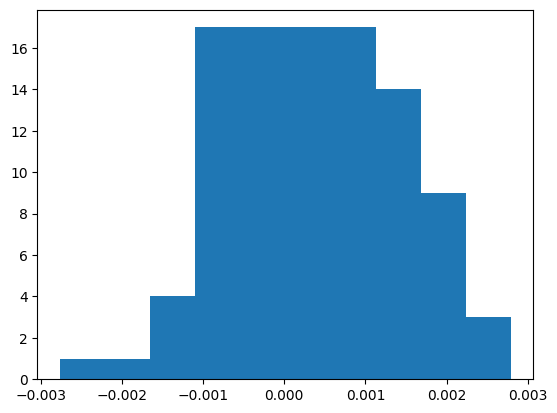

In [27]:
# Convert to array
p_diffs = np.array(p_diffs)
# Plotting
plt.hist(p_diffs);
# The plot apears to be normaly distributed around zero, as expected.

In [28]:
# Get dataframe with all records from treatment group
new_page_df = df2.query('landing_page == "new_page"')
# Compute conversion rate rate for treatment group
new_page_cr = new_page_df.query("converted == 1 ").user_id.nunique()/new_page_df.user_id.nunique()
# Display conversion rate
new_page_cr

0.11880806551510564

In [29]:
# Get dataframe with all records from control group
old_page_df = df2.query('landing_page == "old_page"')
# Compute conversion rate for control group
old_page_cr = old_page_df.query("converted == 1 ").user_id.nunique()/old_page_df.user_id.nunique()
# Display conversion rate
old_page_cr

0.1203863045004612

In [30]:
# Compute the observed difference under the null
obs_diff = new_page_cr - old_page_cr
obs_diff

-0.0015782389853555567

In [31]:
# Create distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

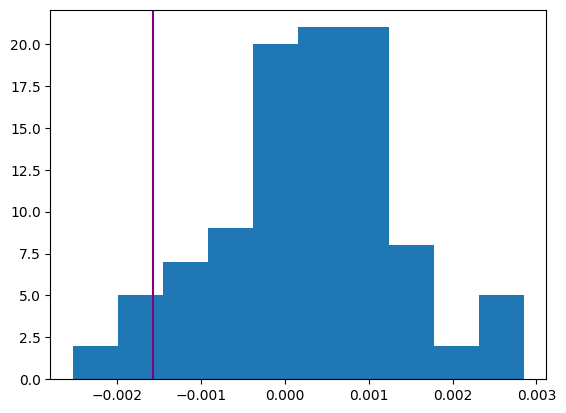

In [32]:
# Plot and see where the observed difference lies
plt.hist(null_vals);
plt.axvline(obs_diff, color='purple')

In [33]:
p_value = (null_vals > obs_diff).mean()
p_value # P-value is greater than 0.05 or 5%

0.97

Summary: P-Value is a probability of observing our statistic or a more extreme statistic from the null hypothesis.
The P-value computed above is greater than the Type I error threshhold of 5%. Thus we fail to reject the null hypothesis.

Statistical test preparation


In [ ]:
# Create variable for Statistical tests
convert_old = df2.query('converted == 1' and 'landing_page == "old_page"')['user_id'].nunique()/df2['user_id'].nunique()
convert_new = df2.query('converted == 1' and 'landing_page == "new_page"')['user_id'].nunique()/df2['user_id'].nunique()
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()

In [ ]:

# Two tail test to determine if p_new and p_old are different from each other
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new, convert_old]), np.array([n_new, n_old]))
# See the result
z_score, p_value 

(-6.15336608934076e-17, 1.0)

In [ ]:

# Test significance of z-score
norm.cdf(z_score)

0.5

In [ ]:

# Tells us what our critical value at 95% confidence is
norm.ppf(1-(0.05/2))

1.959963984540054

In [ ]:

# Create a dummy variable column for which page each user received
df2 = df2.join(pd.get_dummies(df2['landing_page']))

In [ ]:
# Add ab_page column which reflects the values in the treatment column
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,0


In [ ]:

# Attribution Error triggered by scipy version outdate has occured. 
# Possible solution is to run the scripts in another environment, after installing needed versions of scipy, 
# or remain in Jupyter and use following temporary resolution workaround code: https://github.com/statsmodels/statsmodels/issues/3931
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# Fit the Logistic regression model
df2['intercept'] = 1
# Logit regression model for conveted variable and ab_page
logit_mod1 = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [ ]:
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 May 2023   Pseudo R-squ.:               8.077e-06
Time:                        16:23:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [ ]:
np.exp(-0.0150)


0.9851119396030626

Summary: The p-value associated with ab_page is 0.190, which once more is greater than the alpha threshold of 0.05, confirminf that difference between control and ab_page values do not provide us with a statistically significan results. The p-value is different due to the following factors:

The null hypothesis used in Part II asumes the old landing page converts users more than the new page, i.e. 
.
We will fail to reject the null hyphothesis unless there is a prove that new page is definitely better at a Type I error rate of 5%, i.e. 
.

In comparisson the null hypothesis in Part III of this document states there is no difference between the treatment and control groups, i.e. 
Alternative hypotheses states that there is a statistical difference between the treatment and control groups i.e. 

Note: It is always a good idea to include other factor variables into the analysis, provided that they are not interrelated with original variables. Adding more factors into the analysis may give insights for a reason of conversion and allow to predict conversion probability more precisely. In terms of landing pages there are a lot of factors which could affect the conversion rate, e.g.:

Device type ( PC, tablet or mobile) and whether the landing page was adapted to the device.
Localisation to suit users demands in a particular region or their language.
Accessibility, whether a page completed all accessibility tests and is viewable by all users and across devices.
Runtime of the test, which could determine novelty effect or resistance to change.
Potential drawbacks of introducing more data into the model is a risk of interdependence between variables or multicollinearity, i.e. new variables might affect the given variables, which in turn will make interpretation of results more complex or potentially incorrect.